## Using SIVP approach to tracking dominant eigenmodes

We initially use temporal stability analysis to find the $\alpha$ mode: 

In [6]:
import os 
import sys
m_path = os.getcwd()
sys.path.append(m_path)

# import all required modules:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
#from mpmath import findroot
from scipy.linalg import lu, solve_triangular, eig
from numpy.linalg import cond

from stream_functions import StreamFunctions
from boundary_conditions import BoundaryConditions
from temporal_stability import TemporalStability

In [7]:

sf = StreamFunctions(n_wakes=1)
bc = BoundaryConditions(sf)
D  = bc.M_non_dim
A = bc.A_non_dim
B = bc.B_non_dim

In [8]:
#val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':-1, 'c': f'{sf.w}/{sf.alpha}'}
val_set = {'S': 0.2, 'Lambda': -1.1, 'delta': 0.1, 'L':0.0, 's':1}
A_sub = A.subs(val_set)
B_sub = B.subs(val_set)

In [9]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
alpha_r = np.arange(0,20,0.1)
w_vals = np.zeros_like(alpha_r, dtype=complex)
w1_vals = np.zeros_like(alpha_r, dtype=complex)
w2_vals = np.zeros_like(alpha_r, dtype=complex)

for i in range(len(alpha_r)):
    c_val_list, ignore_vals = ts.find_c(alpha_r[i])
    temp_w_vals = c_val_list * alpha_r[i]
    temp_w_vals = temp_w_vals[np.isfinite(temp_w_vals)]
    temp_w_vals = temp_w_vals[np.real(temp_w_vals) < max_threshold]
    if temp_w_vals.shape[0] == 0:
        w_vals[i] = np.nan
        w1_vals[i] = np.nan
        w2_vals[i] = np.nan
    else:
        w1_vals[i] = temp_w_vals[0]
        w2_vals[i] = temp_w_vals[1]
        max_w_val_idx = np.argmax(np.imag(temp_w_vals))
        w_vals[i] = temp_w_vals[max_w_val_idx]

C:\Users\tvivek\AppData\Local\Temp\ipykernel_17260\641951009.py:10: RuntimeWarning: invalid value encountered in multiply
  temp_w_vals = c_val_list * alpha_r[i]


<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_17260\747466451.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

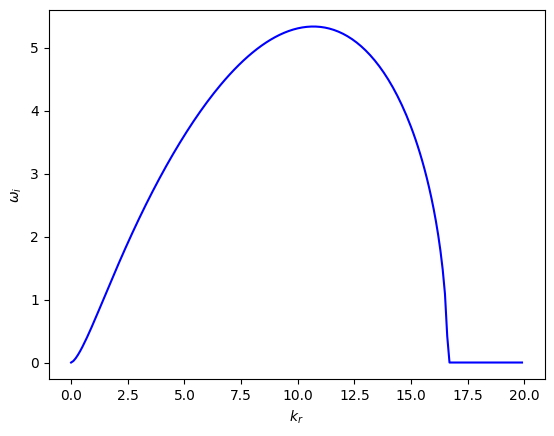

In [10]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w_vals), color='blue')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_17260\3405403774.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

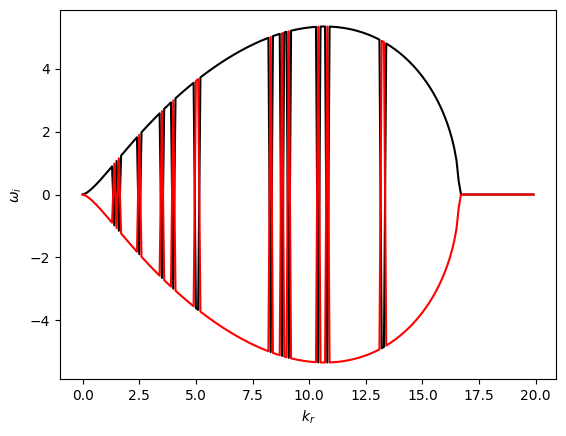

In [11]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w1_vals), color='black')
plt.plot(alpha_r, np.imag(w2_vals), color='red')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

Find the maximum of w_vals and corresponding $k_r$. That $k_r$ will serve as the starting point to get the intial guess for saddle point.

In [12]:
max_imag_w_val = np.max(np.imag(w_vals))
max_imag_w_val_idx = np.argmax(np.imag(w_vals))
k_beg = alpha_r[max_imag_w_val_idx]
w_beg = w_vals[max_imag_w_val_idx]
print(f'k_beg = {np.round(k_beg,3)}')
print(f'w_beg = {np.round(w_beg,3)}')

k_beg = 10.7
w_beg = (13.935+5.336j)


Get the eigenpair $(\mathbf{\hat{q}_1}, \omega_1)$ at the $\alpha$ mode location on the real $k$ line

In [89]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
c_vals, q1_vals = ts.find_c(k_beg)
filter_for_c_vals = [np.isfinite(c_vals)] and c_vals < max_threshold
q1_vals_filtered = []
for i in range(q1_vals.shape[1]):
    if filter_for_c_vals[i]:
        q1_vals_filtered.append(q1_vals[:,i])
q1_hat = np.array(q1_vals_filtered, dtype=complex)
q1_hat = q1_hat.T
c_vals = c_vals[filter_for_c_vals]
w_vals = c_vals * k_beg
if np.imag(w_vals[0]) > np.imag(w_vals[1]):
    w1 = w_vals[0]
else:
    w1 = w_vals[1]
w_vals

array([19.81806599+15.03686953j, 19.81806599-15.03686953j])

In [179]:
class SIVP:
    def __init__(self, sf, bc, val_set=None):
        self.L = bc.A_non_dim * sf.alpha 
        self.M = bc.B_non_dim
        self.L_dot = None
        self.M_dot = None
        self.q1_hat = sp.symbols('q1_hat')
        self.q2_hat = sp.symbols('q2_hat')
        self.q3_hat = sp.symbols('q3_hat')
        self.q4_hat = sp.symbols('q4_hat')
        self.q_hat = sp.Matrix([self.q1_hat, self.q2_hat, self.q3_hat, self.q4_hat])
        self.q_hat_herm = self.q_hat.H
        self.J = None
        self.J11 = None
        self.J12 = None
        self.J21 = None
        self.J22 = None
        self.b = None
        self.b1 = None
        self.b2 = None
        self.val_set = val_set
        self.sf = sf
        self.bc = bc

        self.set_L_M_derivs()
        self.set_Jacobian_matrix()
        self.set_b()
        #self.sub_all()

    def set_L_M_derivs(self):
        self.L_dot = self.L.diff(sf.alpha)
        self.M_dot = self.M.diff(sf.alpha)

    def set_Jacobian_matrix(self):
        self.J11 = self.L - sf.w * self.M
        self.J12 = -self.M * self.q_hat
        self.J21 = self.q_hat_herm
        self.J22 = sp.zeros(1,1)
        self.J = sp.BlockMatrix([[self.J11, self.J12], [self.J21, self.J22]])

    def set_b(self):
        self.b1 = (sf.w * self.M_dot - self.L_dot) * self.q_hat
        self.b2 = sp.zeros(1,1)
        self.b = sp.Matrix.vstack(self.b1, self.b2)

    def sub_all(self, val_set=None):
        if val_set is None:
            if self.val_set is None:
                raise ValueError("val_set must be provided.")
                return
            else:
                val_set = self.val_set

        self.L_sub = self.L.subs(val_set)
        self.M_sub = self.M.subs(val_set)
        self.L_dot_sub = self.L_dot.subs(val_set)
        self.M_dot_sub = self.M_dot.subs(val_set)
        self.J11_sub = self.J11.subs(val_set)
        self.J12_sub = self.J12.subs(val_set)
        self.J21_sub = self.J21.subs(val_set)
        self.J22_sub = self.J22.subs(val_set)
        self.J_sub = self.J.subs(val_set)
        self.b1_sub = self.b1.subs(val_set)
        self.b2_sub = self.b2.subs(val_set)
        self.b_sub = self.b.subs(val_set)

    def sub_alpha(self, alpha):
        self.L_sub = self.L_sub.subs({'alpha': alpha})
        self.M_sub = self.M_sub.subs({'alpha': alpha})
        self.L_dot_sub = self.L_dot_sub.subs({'alpha': alpha})
        self.M_dot_sub = self.M_dot_sub.subs({'alpha': alpha})
        self.J11_sub = self.J11_sub.subs({'alpha': alpha})
        self.J12_sub = self.J12_sub.subs({'alpha': alpha})
        self.J21_sub = self.J21_sub.subs({'alpha': alpha})
        self.J22_sub = self.J22_sub.subs({'alpha': alpha})
        self.J_sub = self.J_sub.subs({'alpha': alpha})
        self.b1_sub = self.b1_sub.subs({'alpha': alpha})
        self.b2_sub = self.b2_sub.subs({'alpha': alpha})
        self.b_sub = self.b_sub.subs({'alpha': alpha})

    def get_ws_q_hats(self):
        L_num = np.array(self.L_sub.evalf()).astype(np.complex128)
        M_num = np.array(self.M_sub.evalf()).astype(np.complex128)
        self.w_vals, self.q_hat_vals = eig(L_num, M_num)
        return self.w_vals, self.q_hat_vals

    def eval_sub(self, w, q_hat):
        m_val_set = {'w': w, 'q1_hat': q_hat[0], 'q2_hat': q_hat[1], 'q3_hat': q_hat[2], 'q4_hat': q_hat[3]}
        self.q_hat_sub = self.q_hat.subs(m_val_set)
        self.q_hat_herm_sub = self.q_hat_herm.subs(m_val_set)
        self.L_sub = self.L_sub.subs(m_val_set)
        self.M_sub = self.M_sub.subs(m_val_set)
        self.L_dot_sub = self.L_dot_sub.subs(m_val_set)
        self.M_dot_sub = self.M_dot_sub.subs(m_val_set)
        self.J11_sub = self.J11_sub.subs(m_val_set)
        self.J12_sub = self.J12_sub.subs(m_val_set)
        self.J21_sub = self.J21_sub.subs(m_val_set)
        self.J22_sub = self.J22_sub.subs(m_val_set)
        self.J_sub = self.J_sub.subs(m_val_set)
        self.b1_sub = self.b1_sub.subs(m_val_set)
        self.b2_sub = self.b2_sub.subs(m_val_set)
        self.b_sub = self.b_sub.subs(m_val_set)

        self.L_num = np.array(self.L_sub.evalf()).astype(np.complex128)
        self.M_num = np.array(self.M_sub.evalf()).astype(np.complex128)
        self.q_hat_num = np.array(self.q_hat_sub.evalf()).astype(np.complex128)
        self.q_hat_herm_num = np.array(self.q_hat_herm_sub.evalf()).astype(np.complex128)
        self.J_num = np.array(self.J_sub.evalf()).astype(np.complex128)
        self.b_num = np.array(self.b_sub.evalf()).astype(np.complex128)
        self.J_num_inv = np.linalg.inv(self.J_num)
        self.L_dot_num = np.array(self.L_dot_sub.evalf()).astype(np.complex128)
        self.M_dot_num = np.array(self.M_dot_sub.evalf()).astype(np.complex128)
    
    def eval_x2(self, x1, dk):
        x2 = x1 + self.J_num_inv @ self.b_num * dk
        return x2

val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':1}
sivp = SIVP(sf, bc)
sivp.sub_all(val_set)
sivp.sub_alpha(k_beg)
ws, q_hats = sivp.get_ws_q_hats()
q_hat = q_hats[:,0]
q_hat = q_hat[:, np.newaxis]
w = ws[0]
w = w[np.newaxis]
x1 = np.vstack((q_hat, w))
sivp.eval_sub(ws[0], q_hats[:,0])
k1 = k_beg
k2 = k1 + 0.1j
dk = k2 - k1
x2 = sivp.eval_x2(x1, dk)
x2

array([[-5.51021687e-01+3.39339034e-01j],
       [ 2.70212977e-01+5.78630360e-01j],
       [-4.16403027e-01+2.79199064e-03j],
       [ 2.08637598e-03+7.97117430e-03j],
       [ 1.98184087e+01+1.51611413e+01j]])

In [ ]:
# construct global map of wi(k):
# From the kr value that corresponds to maximum temporal grwoth rate, increment k with dk, dk being imaginary to fill out kr_max + j*ki.
# We are finding each value vertically in the kr-ki plane first and then for each row, we find the left and the right of the known kr_max + j*ki value
# That recovers the entire global map
# contourf plot the map and verify its correctness

array([[-5.51606185e-01+3.38351025e-01j, -3.39646268e-01+5.45729364e-01j,
         3.32765263e-02+8.37041576e-01j, -2.30425532e-02+5.03823023e-01j],
       [ 2.69213351e-01+5.79070162e-01j, -5.91226418e-01-2.64097303e-01j,
        -6.86778698e-03-1.21550393e-01j, -2.09631383e-02+8.61148221e-01j],
       [-4.16388042e-01+2.08195756e-03j,  6.37159431e-03+4.09162704e-01j,
        -2.47124464e-02-5.31793152e-01j,  7.78337192e-03+3.00849671e-04j],
       [ 2.06990697e-03+7.96861147e-03j, -8.19593643e-03-1.38673819e-03j,
        -4.05617277e-04-4.19317539e-03j, -7.49205520e-04-5.96192650e-02j]])